# 06 - Classificando patologias em toras usando combinação de `OTSU_treshold + LBP + SVM` e normalizando amostras pelo maior elemento de cada histograma

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'normal': 0,
                'broca':1,
                'fissura': 2,
                'musgo': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./patologias_toras.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./patologias_toras.zip/{path}')


# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)
amostra = []

for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img = io.imread(path, as_gray=True)
    
    img_otsu = img >= threshold_otsu(img)

    lbp = local_binary_pattern(image=img_otsu, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = np.zeros(59)
    for i in hist.index:
      arr[int(i)] = hist[i]

    # Realizando normalização pelo maior elemento do histograma
    arr /= arr.max()

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/otsu_lbp_norm2_toras.csv')
data

normal: 107 amostras
broca: 90 amostras
fissura: 109 amostras
musgo: 111 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,0.004687,0.005429,0.0,0.005024,0.0,0.005843,0.0,0.004939,0.0,0.0,...,0.0,0.004087,0.0,0.004051,0.0,0.004075,0.0,1.0,0.036559,0
1,0.004532,0.005795,0.0,0.005216,0.0,0.005876,0.0,0.004819,0.0,0.0,...,0.0,0.011351,0.0,0.010178,0.0,0.010288,0.0,1.0,0.062209,0
2,0.004270,0.005820,0.0,0.003843,0.0,0.005847,0.0,0.003661,0.0,0.0,...,0.0,0.006465,0.0,0.006882,0.0,0.006131,0.0,1.0,0.043413,0
3,0.003999,0.006970,0.0,0.005946,0.0,0.007022,0.0,0.005593,0.0,0.0,...,0.0,0.012515,0.0,0.013046,0.0,0.012402,0.0,1.0,0.069780,0
4,0.004572,0.008454,0.0,0.007579,0.0,0.008371,0.0,0.007330,0.0,0.0,...,0.0,0.013906,0.0,0.014735,0.0,0.014247,0.0,1.0,0.091898,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.003341,0.005922,0.0,0.004859,0.0,0.006302,0.0,0.003720,0.0,0.0,...,0.0,0.016020,0.0,0.016324,0.0,0.014046,0.0,1.0,0.040012,3
356,0.000985,0.001673,0.0,0.001810,0.0,0.001856,0.0,0.002131,0.0,0.0,...,0.0,0.014160,0.0,0.016703,0.0,0.014320,0.0,1.0,0.022844,3
357,0.000982,0.001829,0.0,0.001160,0.0,0.001918,0.0,0.001205,0.0,0.0,...,0.0,0.004908,0.0,0.006291,0.0,0.003614,0.0,1.0,0.012046,3
358,0.005247,0.006049,0.0,0.004934,0.0,0.006032,0.0,0.004969,0.0,0.0,...,0.0,0.005108,0.0,0.005352,0.0,0.005056,0.0,1.0,0.031258,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 1102
              precision    recall  f1-score   support

      normal       0.79      0.76      0.78        25
       broca       0.65      0.77      0.70        26
     fissura       0.82      0.82      0.82        33
       musgo       0.95      0.79      0.86        24

    accuracy                           0.79       108
   macro avg       0.80      0.78      0.79       108
weighted avg       0.80      0.79      0.79       108



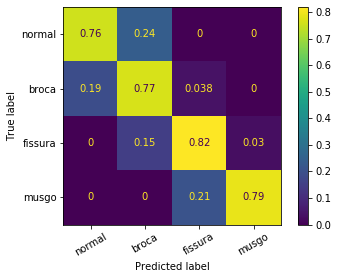

Rodada 1	-	Seed 5931
              precision    recall  f1-score   support

      normal       0.84      0.84      0.84        31
       broca       0.73      0.69      0.71        32
     fissura       0.80      0.83      0.82        24
       musgo       0.91      0.95      0.93        21

    accuracy                           0.81       108
   macro avg       0.82      0.83      0.82       108
weighted avg       0.81      0.81      0.81       108



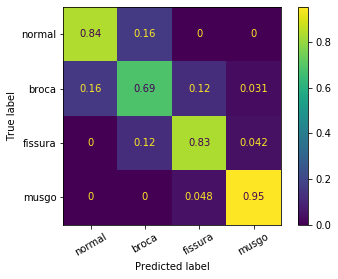

Rodada 2	-	Seed 6696
              precision    recall  f1-score   support

      normal       0.83      0.76      0.79        25
       broca       0.53      0.83      0.65        24
     fissura       1.00      0.67      0.80        39
       musgo       0.95      1.00      0.98        20

    accuracy                           0.79       108
   macro avg       0.83      0.81      0.80       108
weighted avg       0.85      0.79      0.80       108



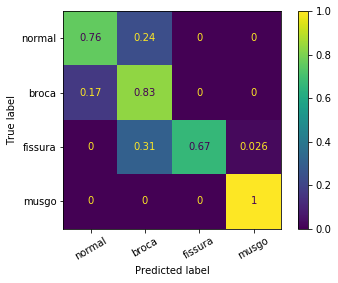

Rodada 3	-	Seed 4792
              precision    recall  f1-score   support

      normal       0.82      0.93      0.87        30
       broca       0.84      0.62      0.71        34
     fissura       0.61      0.83      0.70        23
       musgo       0.94      0.81      0.87        21

    accuracy                           0.79       108
   macro avg       0.81      0.80      0.79       108
weighted avg       0.81      0.79      0.79       108



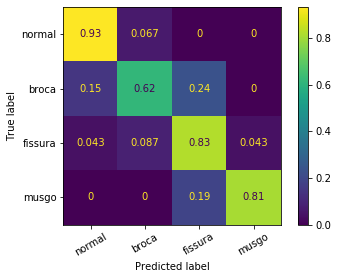

Rodada 4	-	Seed 1649
              precision    recall  f1-score   support

      normal       0.83      0.83      0.83        29
       broca       0.64      0.78      0.70        27
     fissura       0.92      0.71      0.80        31
       musgo       0.91      0.95      0.93        21

    accuracy                           0.81       108
   macro avg       0.82      0.82      0.81       108
weighted avg       0.82      0.81      0.81       108



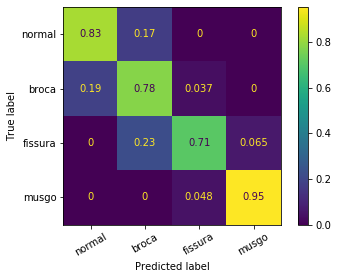

Rodada 5	-	Seed 7230
              precision    recall  f1-score   support

      normal       0.87      0.87      0.87        30
       broca       0.73      0.73      0.73        26
     fissura       0.69      0.85      0.76        26
       musgo       0.95      0.73      0.83        26

    accuracy                           0.80       108
   macro avg       0.81      0.79      0.80       108
weighted avg       0.81      0.80      0.80       108



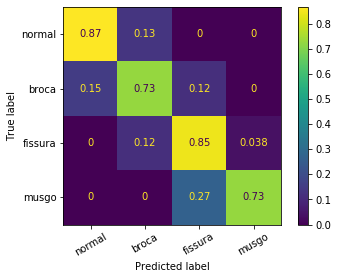

Rodada 6	-	Seed 7467
              precision    recall  f1-score   support

      normal       0.83      0.86      0.84        22
       broca       0.81      0.73      0.77        30
     fissura       0.73      0.79      0.76        24
       musgo       0.91      0.91      0.91        32

    accuracy                           0.82       108
   macro avg       0.82      0.82      0.82       108
weighted avg       0.83      0.82      0.82       108



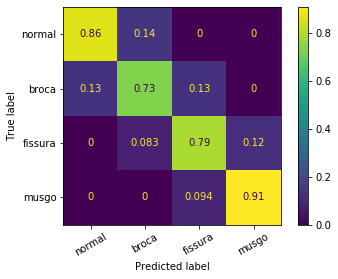

Rodada 7	-	Seed 3684
              precision    recall  f1-score   support

      normal       0.85      0.88      0.86        32
       broca       0.79      0.66      0.72        29
     fissura       0.72      0.96      0.82        24
       musgo       1.00      0.83      0.90        23

    accuracy                           0.82       108
   macro avg       0.84      0.83      0.83       108
weighted avg       0.84      0.82      0.82       108



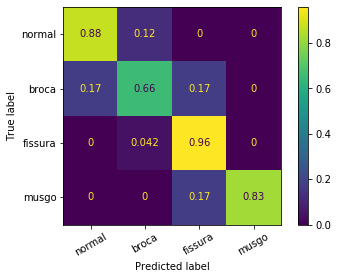

Rodada 8	-	Seed 923
              precision    recall  f1-score   support

      normal       0.88      0.77      0.82        30
       broca       0.71      0.80      0.75        25
     fissura       0.84      0.95      0.89        22
       musgo       1.00      0.94      0.97        31

    accuracy                           0.86       108
   macro avg       0.86      0.86      0.86       108
weighted avg       0.87      0.86      0.86       108



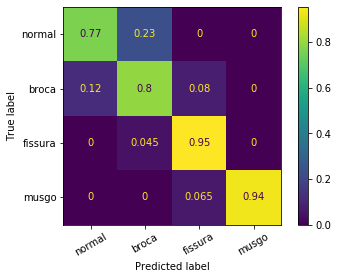

Rodada 9	-	Seed 2418
              precision    recall  f1-score   support

      normal       0.93      0.87      0.90        30
       broca       0.67      0.73      0.70        22
     fissura       0.70      0.77      0.73        30
       musgo       0.87      0.77      0.82        26

    accuracy                           0.79       108
   macro avg       0.79      0.78      0.78       108
weighted avg       0.80      0.79      0.79       108



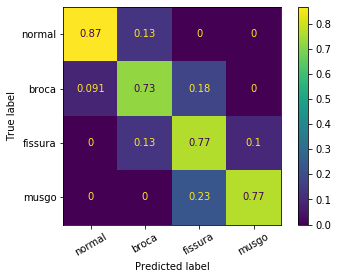

Rodada 10	-	Seed 6138
              precision    recall  f1-score   support

      normal       0.95      0.83      0.88        23
       broca       0.80      0.93      0.86        30
     fissura       0.86      0.80      0.83        30
       musgo       0.88      0.88      0.88        25

    accuracy                           0.86       108
   macro avg       0.87      0.86      0.86       108
weighted avg       0.87      0.86      0.86       108



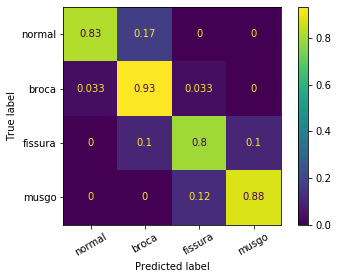

Rodada 11	-	Seed 5430
              precision    recall  f1-score   support

      normal       0.88      0.73      0.80        30
       broca       0.69      0.85      0.76        26
     fissura       0.74      0.91      0.82        22
       musgo       1.00      0.80      0.89        30

    accuracy                           0.81       108
   macro avg       0.83      0.82      0.82       108
weighted avg       0.84      0.81      0.82       108



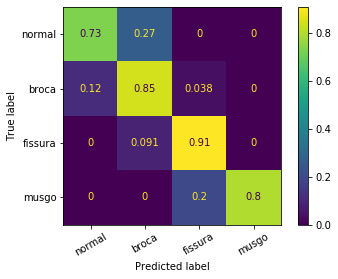

Rodada 12	-	Seed 924
              precision    recall  f1-score   support

      normal       0.84      0.81      0.82        26
       broca       0.81      0.70      0.75        30
     fissura       0.67      0.91      0.77        22
       musgo       0.93      0.83      0.88        30

    accuracy                           0.81       108
   macro avg       0.81      0.81      0.80       108
weighted avg       0.82      0.81      0.81       108



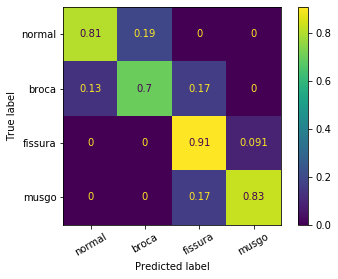

Rodada 13	-	Seed 7246
              precision    recall  f1-score   support

      normal       0.93      0.93      0.93        27
       broca       0.85      0.81      0.83        27
     fissura       0.78      0.86      0.82        21
       musgo       0.97      0.94      0.95        33

    accuracy                           0.89       108
   macro avg       0.88      0.88      0.88       108
weighted avg       0.89      0.89      0.89       108



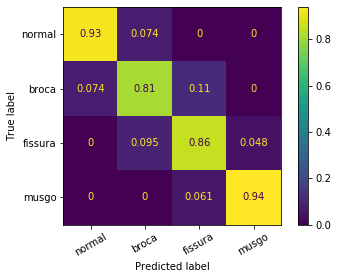

Rodada 14	-	Seed 3641
              precision    recall  f1-score   support

      normal       0.81      0.81      0.81        26
       broca       0.63      0.74      0.68        23
     fissura       0.77      0.74      0.75        31
       musgo       0.88      0.79      0.83        28

    accuracy                           0.77       108
   macro avg       0.77      0.77      0.77       108
weighted avg       0.78      0.77      0.77       108



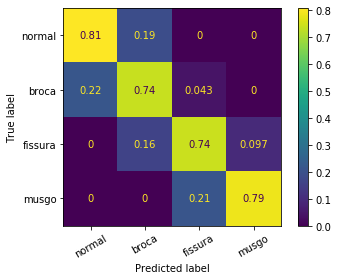

Rodada 15	-	Seed 7053
              precision    recall  f1-score   support

      normal       0.72      0.91      0.81        23
       broca       0.89      0.69      0.77        35
     fissura       0.67      0.76      0.71        21
       musgo       0.89      0.86      0.88        29

    accuracy                           0.80       108
   macro avg       0.79      0.81      0.79       108
weighted avg       0.81      0.80      0.80       108



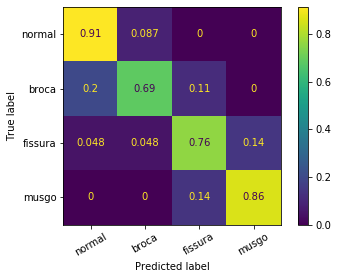

Rodada 16	-	Seed 3010
              precision    recall  f1-score   support

      normal       0.90      0.90      0.90        29
       broca       0.78      0.83      0.81        30
     fissura       0.84      0.81      0.82        26
       musgo       0.95      0.91      0.93        23

    accuracy                           0.86       108
   macro avg       0.87      0.86      0.86       108
weighted avg       0.86      0.86      0.86       108



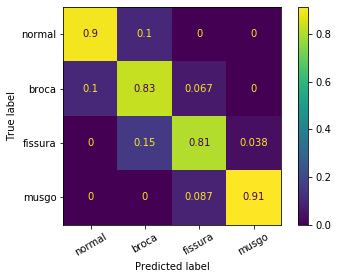

Rodada 17	-	Seed 7959
              precision    recall  f1-score   support

      normal       0.91      0.87      0.89        23
       broca       0.77      0.89      0.83        27
     fissura       0.80      0.80      0.80        30
       musgo       0.92      0.82      0.87        28

    accuracy                           0.84       108
   macro avg       0.85      0.84      0.85       108
weighted avg       0.85      0.84      0.84       108



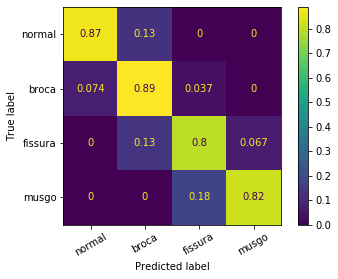

Rodada 18	-	Seed 7451
              precision    recall  f1-score   support

      normal       0.89      0.83      0.86        29
       broca       0.69      0.75      0.72        24
     fissura       0.70      0.76      0.73        21
       musgo       0.94      0.88      0.91        34

    accuracy                           0.81       108
   macro avg       0.80      0.81      0.80       108
weighted avg       0.82      0.81      0.82       108



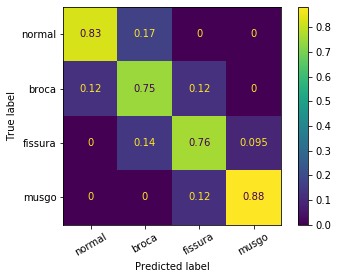

Rodada 19	-	Seed 1979
              precision    recall  f1-score   support

      normal       0.88      0.85      0.87        27
       broca       0.75      0.86      0.80        28
     fissura       0.80      0.71      0.75        28
       musgo       0.84      0.84      0.84        25

    accuracy                           0.81       108
   macro avg       0.82      0.82      0.82       108
weighted avg       0.82      0.81      0.81       108



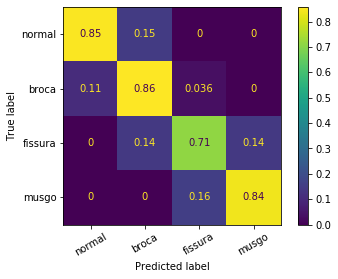

Rodada 20	-	Seed 2760
              precision    recall  f1-score   support

      normal       0.88      0.88      0.88        33
       broca       0.87      0.77      0.82        35
     fissura       0.84      1.00      0.91        21
       musgo       1.00      1.00      1.00        19

    accuracy                           0.89       108
   macro avg       0.90      0.91      0.90       108
weighted avg       0.89      0.89      0.89       108



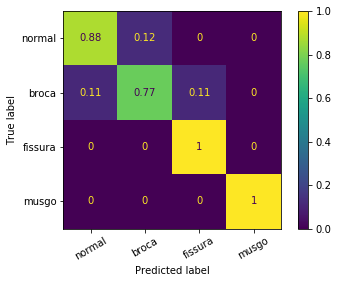

Rodada 21	-	Seed 3664
              precision    recall  f1-score   support

      normal       0.88      0.85      0.86        33
       broca       0.65      0.65      0.65        23
     fissura       0.82      0.85      0.84        27
       musgo       0.96      0.96      0.96        25

    accuracy                           0.83       108
   macro avg       0.83      0.83      0.83       108
weighted avg       0.83      0.83      0.83       108



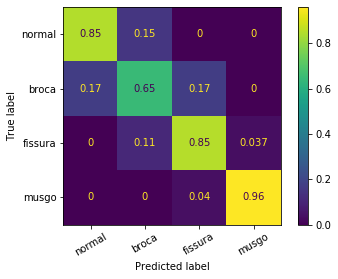

Rodada 22	-	Seed 1880
              precision    recall  f1-score   support

      normal       0.79      0.79      0.79        24
       broca       0.73      0.71      0.72        34
     fissura       0.66      0.78      0.71        27
       musgo       0.89      0.74      0.81        23

    accuracy                           0.75       108
   macro avg       0.77      0.75      0.76       108
weighted avg       0.76      0.75      0.75       108



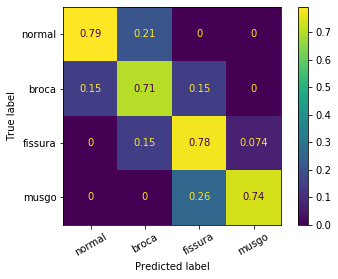

Rodada 23	-	Seed 7881
              precision    recall  f1-score   support

      normal       0.93      0.81      0.87        32
       broca       0.77      0.89      0.83        27
     fissura       0.90      0.90      0.90        29
       musgo       0.90      0.90      0.90        20

    accuracy                           0.87       108
   macro avg       0.87      0.87      0.87       108
weighted avg       0.88      0.87      0.87       108



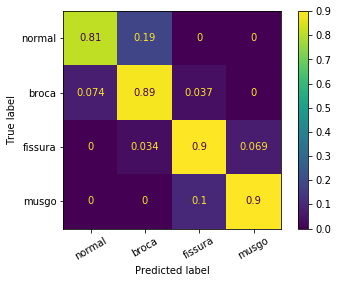

Rodada 24	-	Seed 3565
              precision    recall  f1-score   support

      normal       0.84      0.84      0.84        25
       broca       0.71      0.85      0.77        26
     fissura       0.85      0.71      0.77        31
       musgo       0.88      0.88      0.88        26

    accuracy                           0.81       108
   macro avg       0.82      0.82      0.82       108
weighted avg       0.82      0.81      0.81       108



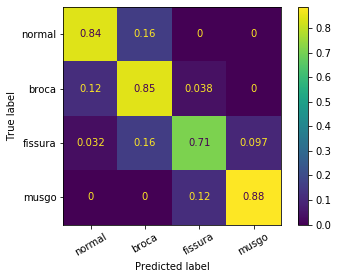

Rodada 25	-	Seed 6653
              precision    recall  f1-score   support

      normal       0.93      0.96      0.95        27
       broca       0.80      0.86      0.83        28
     fissura       0.75      0.84      0.79        25
       musgo       1.00      0.79      0.88        28

    accuracy                           0.86       108
   macro avg       0.87      0.86      0.86       108
weighted avg       0.87      0.86      0.86       108



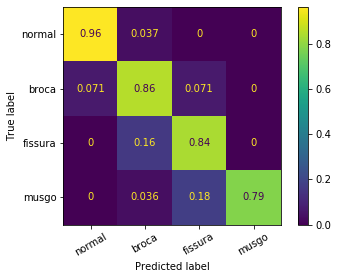

Rodada 26	-	Seed 16
              precision    recall  f1-score   support

      normal       0.89      0.86      0.88        29
       broca       0.77      0.83      0.80        29
     fissura       0.74      0.83      0.78        24
       musgo       0.95      0.81      0.88        26

    accuracy                           0.83       108
   macro avg       0.84      0.83      0.83       108
weighted avg       0.84      0.83      0.84       108



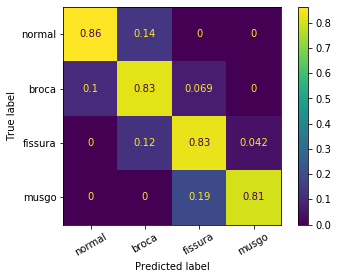

Rodada 27	-	Seed 4996
              precision    recall  f1-score   support

      normal       0.82      0.90      0.86        20
       broca       0.79      0.79      0.79        28
     fissura       0.90      0.84      0.87        31
       musgo       0.93      0.93      0.93        29

    accuracy                           0.86       108
   macro avg       0.86      0.86      0.86       108
weighted avg       0.86      0.86      0.86       108



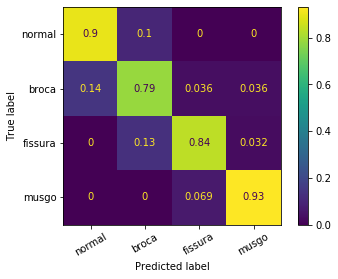

Rodada 28	-	Seed 5422
              precision    recall  f1-score   support

      normal       0.92      0.74      0.82        31
       broca       0.68      0.75      0.71        28
     fissura       0.74      0.83      0.78        24
       musgo       0.92      0.92      0.92        25

    accuracy                           0.81       108
   macro avg       0.81      0.81      0.81       108
weighted avg       0.82      0.81      0.81       108



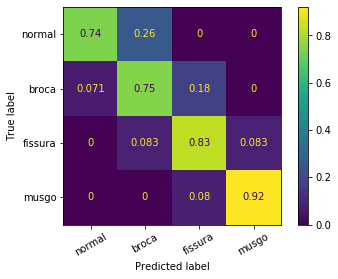

Rodada 29	-	Seed 5460
              precision    recall  f1-score   support

      normal       0.64      0.89      0.74        18
       broca       0.81      0.67      0.73        33
     fissura       0.81      0.79      0.80        28
       musgo       0.90      0.90      0.90        29

    accuracy                           0.80       108
   macro avg       0.79      0.81      0.79       108
weighted avg       0.81      0.80      0.80       108



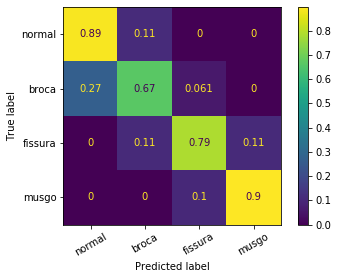

In [4]:
df = pd.read_csv('./csvs/otsu_lbp_norm2_toras.csv')
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

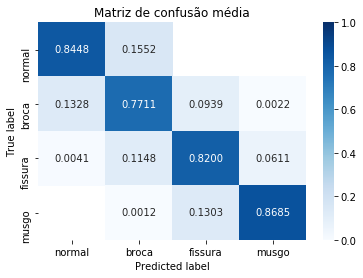

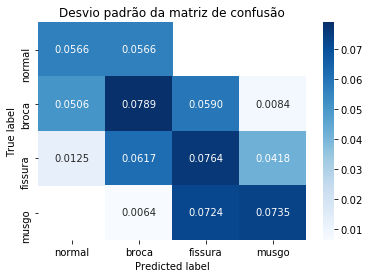

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia  f1-normal   f1-broca  f1-fissura   f1-musgo
count  30.000000  30.000000  30.000000   30.000000  30.000000
mean    0.821914   0.848075   0.753062    0.795386   0.896866
std     0.035042   0.044687   0.056917    0.053763   0.047677
min     0.750000   0.744186   0.645161    0.703704   0.809524
25%     0.796296   0.821429   0.711864    0.758966   0.872596
50%     0.814815   0.857143   0.752358    0.800000   0.892720
75%     0.856481   0.876645   0.800000    0.820617   0.930233
max     0.888889   0.945455   0.861538    0.913043   1.000000


Acurácia,f1-normal,f1-broca,f1-fissura,f1-musgo
0.787037,0.775510,0.701754,0.818182,0.863636
0.814815,0.838710,0.709677,0.816327,0.930233
0.787037,0.791667,0.645161,0.800000,0.975610
0.787037,0.875000,0.711864,0.703704,0.871795
0.805556,0.827586,0.700000,0.800000,0.930233
0.796296,0.866667,0.730769,0.758621,0.826087
0.824074,0.844444,0.771930,0.760000,0.906250
0.824074,0.861538,0.716981,0.821429,0.904762
0.861111,0.821429,0.754717,0.893617,0.966667
0.787037,0.896552,0.695652,0.730159,0.816327


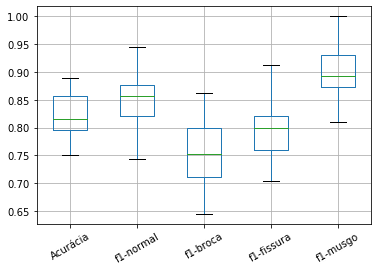

In [6]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')